<img src='https://www.actris.eu/sites/default/files/inline-images/Actris%20logo.png' width=200 align=right>

# ACTRIS DC

## Access ACTRIS Aerosol Remote Sensing data

The goal of this notebook is to provide guide on how to access aerosol remote sensing data.

Let's get started!

### Import libraries

In [12]:
from pathlib import Path
import datetime

# Library for working with netCDF files
import xarray as xr

# Libraries for working with JSON files, making HTTP requests, and handling file system operations
import requests
import netCDF4
import numpy as np

# Library for plotting data
import matplotlib.pyplot as plt

# Library for working with zip files
import zipfile

from ipywidgets import IntProgress
from IPython.display import display

### Download

We're going to use ARES REST API to search and download netCDF4 files. For more information, see <https://data.earlinet.org/api/swagger-ui/#>.

Let's download an optical product from Potenza in 2024. This product contains aerosol optical properties, like aerosol particle backscatter coefficient, aerosol particle light extinction coefficient, aerosol particle light extinction-to-backscatter ratio, and aerosol particle light backscatter linear depolarization ratio.

For this example, we use the method "GET opticalproducts" that returns all the metadata (in JSON format) related to optical products matching search criteria.  
To narrow our search, we set specific search criteria: time interval (from April 28, 2024 at 20:15 to April 28, 2024 at 21:15), facility (Potenza - POT), file type (Extinction - e), and emission wavelength (532 nm).

In [13]:
outdir = Path("static/ares-data")
outdir.mkdir(exist_ok=True)
r = requests.get("https://data.earlinet.org/api/services/restapi/opticalproducts/", 
                 params={"fromDate": "2024-04-28",
                         "fromDayTime": "20:15:00",
                         "toDate": "2024-04-28",
                         "toDayTime": "21:15:00", 
                         "stations": "POT", 
                         "ewls": "532",
                        })
r.raise_for_status()
metadata = r.json()
#display(metadata)

The API returns a list containing metadata of optical products matching search criteria (6 in this example).
We want to download the NetCDF files now. 
To do this, we extract the product IDs and filenames from the metadata. 

In [14]:
ids_filenames = dict()
for md in metadata: 
    ids_filenames.update({md.get("ID") : md.get("Filename")})
display(ids_filenames)

{144438: 'EARLINET_AerRemSen_pot_Lev01_b0532_202404282016_202404282050_v01_qc03.nc',
 144485: 'EARLINET_AerRemSen_pot_Lev01_b0532_202404282016_202404282111_v01_qc03.nc',
 144490: 'EARLINET_AerRemSen_pot_Lev01_b0532_202404282111_202404282206_v01_qc03.nc',
 144441: 'EARLINET_AerRemSen_pot_Lev01_e0532_202404282016_202404282050_v01_qc03.nc',
 144488: 'EARLINET_AerRemSen_pot_Lev01_e0532_202404282016_202404282111_v01_qc03.nc',
 144493: 'EARLINET_AerRemSen_pot_Lev01_e0532_202404282111_202404282206_v01_qc03.nc'}

Then we use the product IDs to download related NetCDF files with another API method: GET "opticalproducts/id/{id}/downloads".

In [15]:
progress = IntProgress(min=0, max=len(ids_filenames), description="Download:")
display(progress)
for key, value in ids_filenames.items():
    get_request = "https://data.earlinet.org/api/services/restapi/opticalproducts/id/{id}/downloads"
    get_request = get_request.replace("{id}", str(key))
    r = requests.get(get_request)
    r.raise_for_status()
    (outdir / value).write_bytes(r.content)
    progress.value += 1    

IntProgress(value=0, description='Download:', max=6)

### Analyse

In this example we have downloaded 6 NetCDF files. 
We want to focus on the e (Extinction) file "EARLINET_AerRemSen_pot_Lev01_e0532_202404282016_202404282111_v01_qc03.nc" (Id 144488), and on its corresponding b (Backscatter) file, named "EARLINET_AerRemSen_pot_Lev01_b0532_202404282016_202404282111_v01_qc03.nc" (Id 144485). 
Let's open these files and analyse them. 

To explore the content of the files, we use the xarray Python library. The xarray library allows the user to click on and inspect different parts of the dataset such as "Data variables" or "Attributes". 

In [16]:
filename_ext = "EARLINET_AerRemSen_pot_Lev01_e0532_202404282016_202404282111_v01_qc03.nc"
filename_bsc = "EARLINET_AerRemSen_pot_Lev01_b0532_202404282016_202404282111_v01_qc03.nc"
ds_ext = xr.open_dataset(outdir / filename_ext)
ds_bsc = xr.open_dataset(outdir / filename_bsc)

display("e File " + filename_ext)
display(ds_ext)
display ("b File " + filename_bsc)
display(ds_bsc)

'e File EARLINET_AerRemSen_pot_Lev01_e0532_202404282016_202404282111_v01_qc03.nc'

<xarray.Dataset>
Dimensions:                                         (time: 1, nv: 2,
                                                     altitude: 166,
                                                     wavelength: 1)
Coordinates:
  * time                                            (time) datetime64[ns] 202...
  * altitude                                        (altitude) float64 1.03e+...
  * wavelength                                      (wavelength) float32 532.0
    longitude                                       float32 ...
    latitude                                        float32 ...
Dimensions without coordinates: nv
Data variables: (12/31)
    time_bounds                                     (time, nv) datetime64[ns] ...
    backscatter_calibration_value                   (wavelength) float32 ...
    extinction_assumed_wavelength_dependence        (wavelength) float32 ...
    error_retrieval_method                          (wavelength) float32 ...
    backscatter_evaluation_method                   (wavelength) float32 ...
    backscatter_calibration_range_search_algorithm  (wavelength) float32 ...
    ...                                              ...
    user_defined_category                           float64 ...
    backscatter_calibration_range                   (wavelength, nv) float32 ...
    backscatter_calibration_search_range            (wavelength, nv) float32 ...
    cloud_mask_type                                 float32 ...
    scc_product_type                                float32 ...
    cloud_mask                                      (time, altitude) float32 ...
Attributes: (12/35)
    Conventions:                          CF-1.7
    title:                                Profiles of aerosol optical properties
    source:                               Ground based LIDAR measurements
    references:                           Project website at http://www.earli...
    history:                              2024-04-29T20:11Z : Assigned versio...
    station_ID:                           pot
    ...                                   ...
    scc_version_description:              SCC vers. 5.2.8 (HiRELPP vers. 1.1....
    processor_name:                       ELDA
    processor_version:                    3.4.8.1
    __file_format_version:                2.1
    input_file:                           pot_002_0002100_202404282016_202404...
    overlap_correction_file:

'b File EARLINET_AerRemSen_pot_Lev01_b0532_202404282016_202404282111_v01_qc03.nc'

<xarray.Dataset>
Dimensions:                                         (time: 1, nv: 2,
                                                     altitude: 167,
                                                     wavelength: 1)
Coordinates:
  * time                                            (time) datetime64[ns] 202...
  * altitude                                        (altitude) float64 970.0 ...
  * wavelength                                      (wavelength) float32 532.0
    longitude                                       float32 ...
    latitude                                        float32 ...
Dimensions without coordinates: nv
Data variables: (12/29)
    time_bounds                                     (time, nv) datetime64[ns] ...
    backscatter_calibration_value                   (wavelength) float32 ...
    error_retrieval_method                          (wavelength) float32 ...
    backscatter_evaluation_method                   (wavelength) float32 ...
    backscatter_calibration_range_search_algorithm  (wavelength) float32 ...
    raman_backscatter_algorithm                     (wavelength) float32 ...
    ...                                              ...
    user_defined_category                           float64 ...
    backscatter_calibration_range                   (wavelength, nv) float32 ...
    backscatter_calibration_search_range            (wavelength, nv) float32 ...
    cloud_mask_type                                 float32 ...
    scc_product_type                                float32 ...
    cloud_mask                                      (time, altitude) float32 ...
Attributes: (12/35)
    Conventions:                          CF-1.7
    title:                                Profiles of aerosol optical properties
    source:                               Ground based LIDAR measurements
    references:                           Project website at http://www.earli...
    history:                              2024-04-29T20:11Z : Assigned versio...
    station_ID:                           pot
    ...                                   ...
    scc_version_description:              SCC vers. 5.2.8 (HiRELPP vers. 1.1....
    processor_name:                       ELDA
    processor_version:                    3.4.8.1
    __file_format_version:                2.1
    input_file:                           pot_007_0002092_202404282016_202404...
    overlap_correction_file:

### Plot the datasets

We can see that the two files contain complimentary properties, or variables. 
Let's plot some of them.
We will plot the aerosol particle light extinction coefficient and the aerosol particle light extinction-to-backscatter ratio from the e file; the aerosol particle backscatter coefficient and the aerosol particle light backscatter linear depolarization ratio from the b file. 


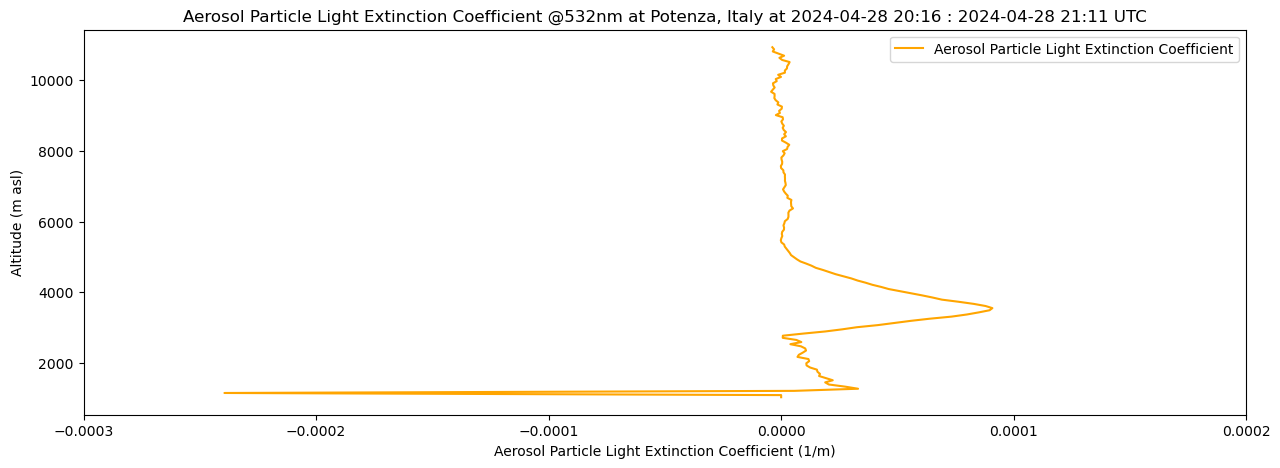

In [17]:
# Choosing the variables we want to plot from "Data variables"
extinction_ds = ds_ext.extinction
extinction_ds = extinction_ds.fillna(0)
altitude_ds = ds_ext.altitude

# Plotting the data
plt.figure(figsize=(15, 5))
plt.plot(extinction_ds[0][0][:], altitude_ds[:], label='Aerosol Particle Light Extinction Coefficient', color="orange")

plt.legend()
plt.ylabel('Altitude (m asl)')
plt.xlabel('Aerosol Particle Light Extinction Coefficient (1/m)')
plt.xlim(-0.0003,0.0002)
plt.title('Aerosol Particle Light Extinction Coefficient @532nm at Potenza, Italy at 2024-04-28 20:16 : 2024-04-28 21:11 UTC')
plt.show()

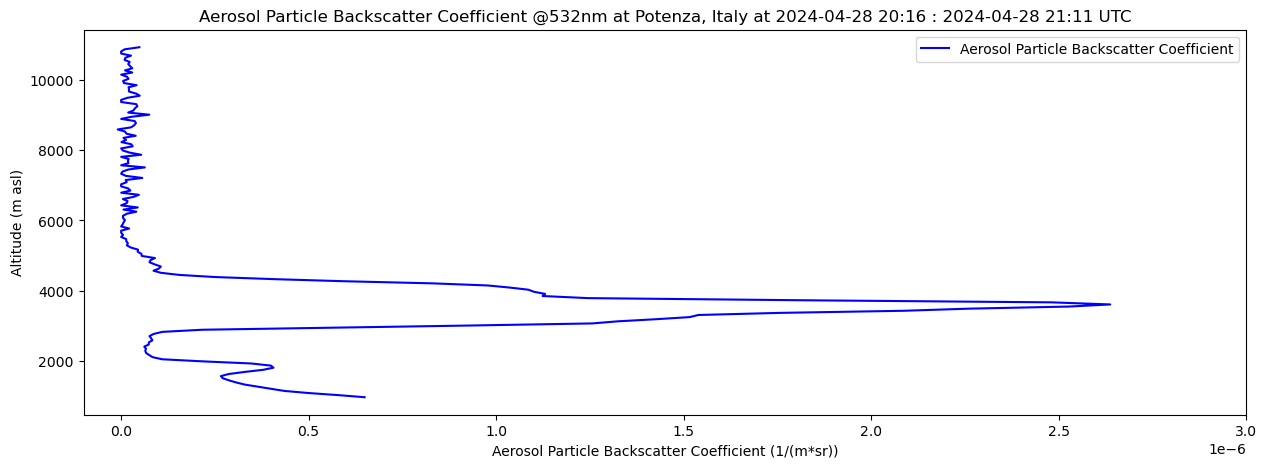

In [18]:
# Choosing the variables we want to plot from "Data variables"
backscatter_ds = ds_bsc.backscatter
backscatter_ds = backscatter_ds.fillna(0)
altitude_ds = ds_bsc.altitude

# Plotting the data
plt.figure(figsize=(15, 5))
plt.plot(backscatter_ds[0][0][:], altitude_ds[:], label='Aerosol Particle Backscatter Coefficient', color="blue")

plt.legend()
plt.ylabel('Altitude (m asl)')
plt.xlabel('Aerosol Particle Backscatter Coefficient (1/(m*sr))')
plt.xlim(-0.0000001,0.000003)
plt.title('Aerosol Particle Backscatter Coefficient @532nm at Potenza, Italy at 2024-04-28 20:16 : 2024-04-28 21:11 UTC')
plt.show()

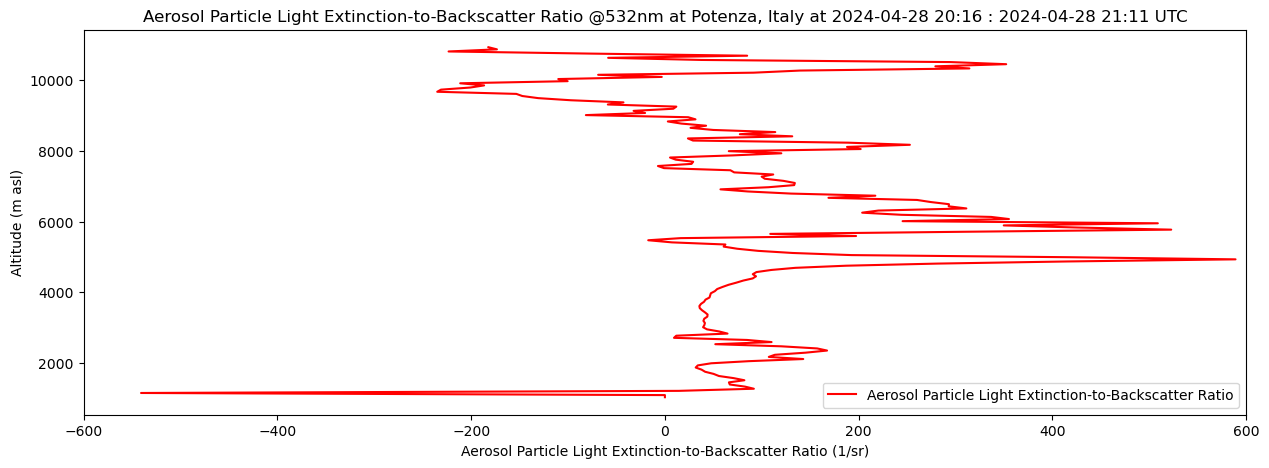

In [19]:
# Choosing the variables we want to plot from "Data variables"
lidarratio_ds = ds_ext.lidarratio
lidarratio_ds = lidarratio_ds.fillna(0)
altitude_ds = ds_ext.altitude

# Plotting the data
plt.figure(figsize=(15, 5))
plt.plot(lidarratio_ds[0][0][:], altitude_ds[:], label='Aerosol Particle Light Extinction-to-Backscatter Ratio', color="red")

plt.legend()
plt.ylabel('Altitude (m asl)')
plt.xlabel('Aerosol Particle Light Extinction-to-Backscatter Ratio (1/sr)')
plt.xlim(-600,600)
plt.title('Aerosol Particle Light Extinction-to-Backscatter Ratio @532nm at Potenza, Italy at 2024-04-28 20:16 : 2024-04-28 21:11 UTC')
plt.show()

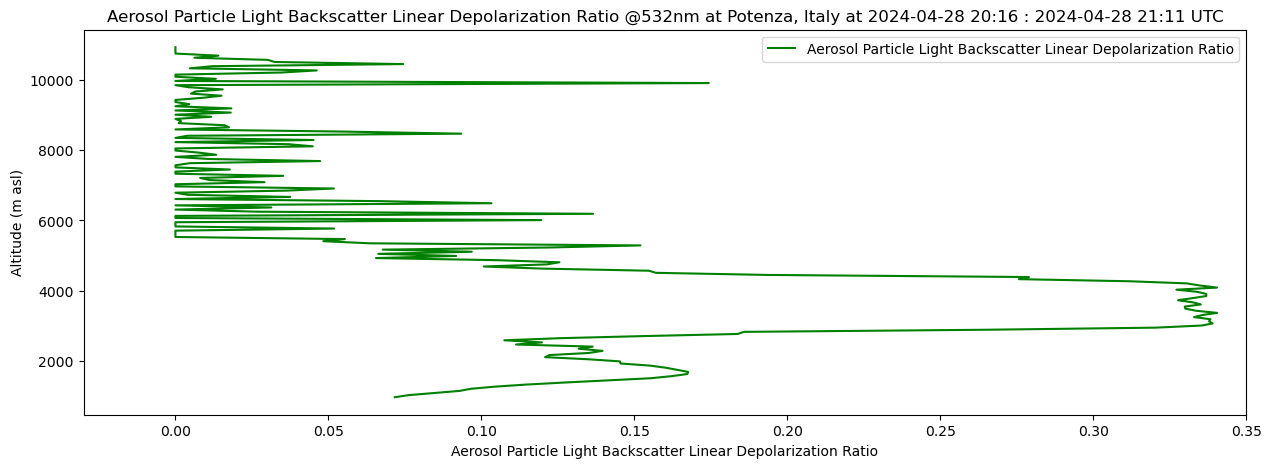

In [20]:
# Choosing the variables we want to plot from "Data variables"
particledep_ds = ds_bsc.particledepolarization
particledep_ds = particledep_ds.fillna(0)
altitude_ds = ds_bsc.altitude

# Plotting the data
plt.figure(figsize=(15, 5))
plt.plot(particledep_ds[0][0][:], altitude_ds[:], label='Aerosol Particle Light Backscatter Linear Depolarization Ratio', color="green")

plt.legend()
plt.ylabel('Altitude (m asl)')
plt.xlabel('Aerosol Particle Light Backscatter Linear Depolarization Ratio')
plt.xlim(-0.03,0.35)
plt.title('Aerosol Particle Light Backscatter Linear Depolarization Ratio @532nm at Potenza, Italy at 2024-04-28 20:16 : 2024-04-28 21:11 UTC')
plt.show()

### Conclusion

The aerosol layer extending between 2.7 and 5.5 km is related to desert dust intrusion over Potenza.
This is clearly identified by the aerosol particle light extinction-to-backscatter ratio (also called lidar ratio) at 532 nm of around 40 sr and the aerosol particle light backscatter linear depolarization ratio at 532nm of 0.33. 